# BM3D Rust Verification & Benchmarking

This notebook verifies the new Rust-backend implementation of BM3DORNL. 
It covers:
1.  **Synthetic Benchmark**: Performance testing on generated noise.
2.  **Real Data Comparison**: Comparing 'Generic' BM3D vs 'Streak Removal' mode for ring artifact reduction.

**Note**: This notebook uses the updated `bm3dornl` package with colored noise support.

In [1]:
import numpy as np
import time
import h5py
import matplotlib.pyplot as plt
from bm3dornl.bm3d import bm3d_ring_artifact_removal

## 2. Real Data Verification (Sinograms)

Comparing Generic BM3D (White Noise) vs Streak Mode (Colored Noise).

In [2]:
# Use flat parameters with canonical names (aligned with Rust core)
patch_size = 8
max_matches = 32

Loaded Sinogram (Slice Y=270), Shape: (591, 620)
Generic Time: 0.1877s
Streak Mode Time: 0.1931s
PSNR Generic: 46.47 dB
PSNR Streak:  45.21 dB


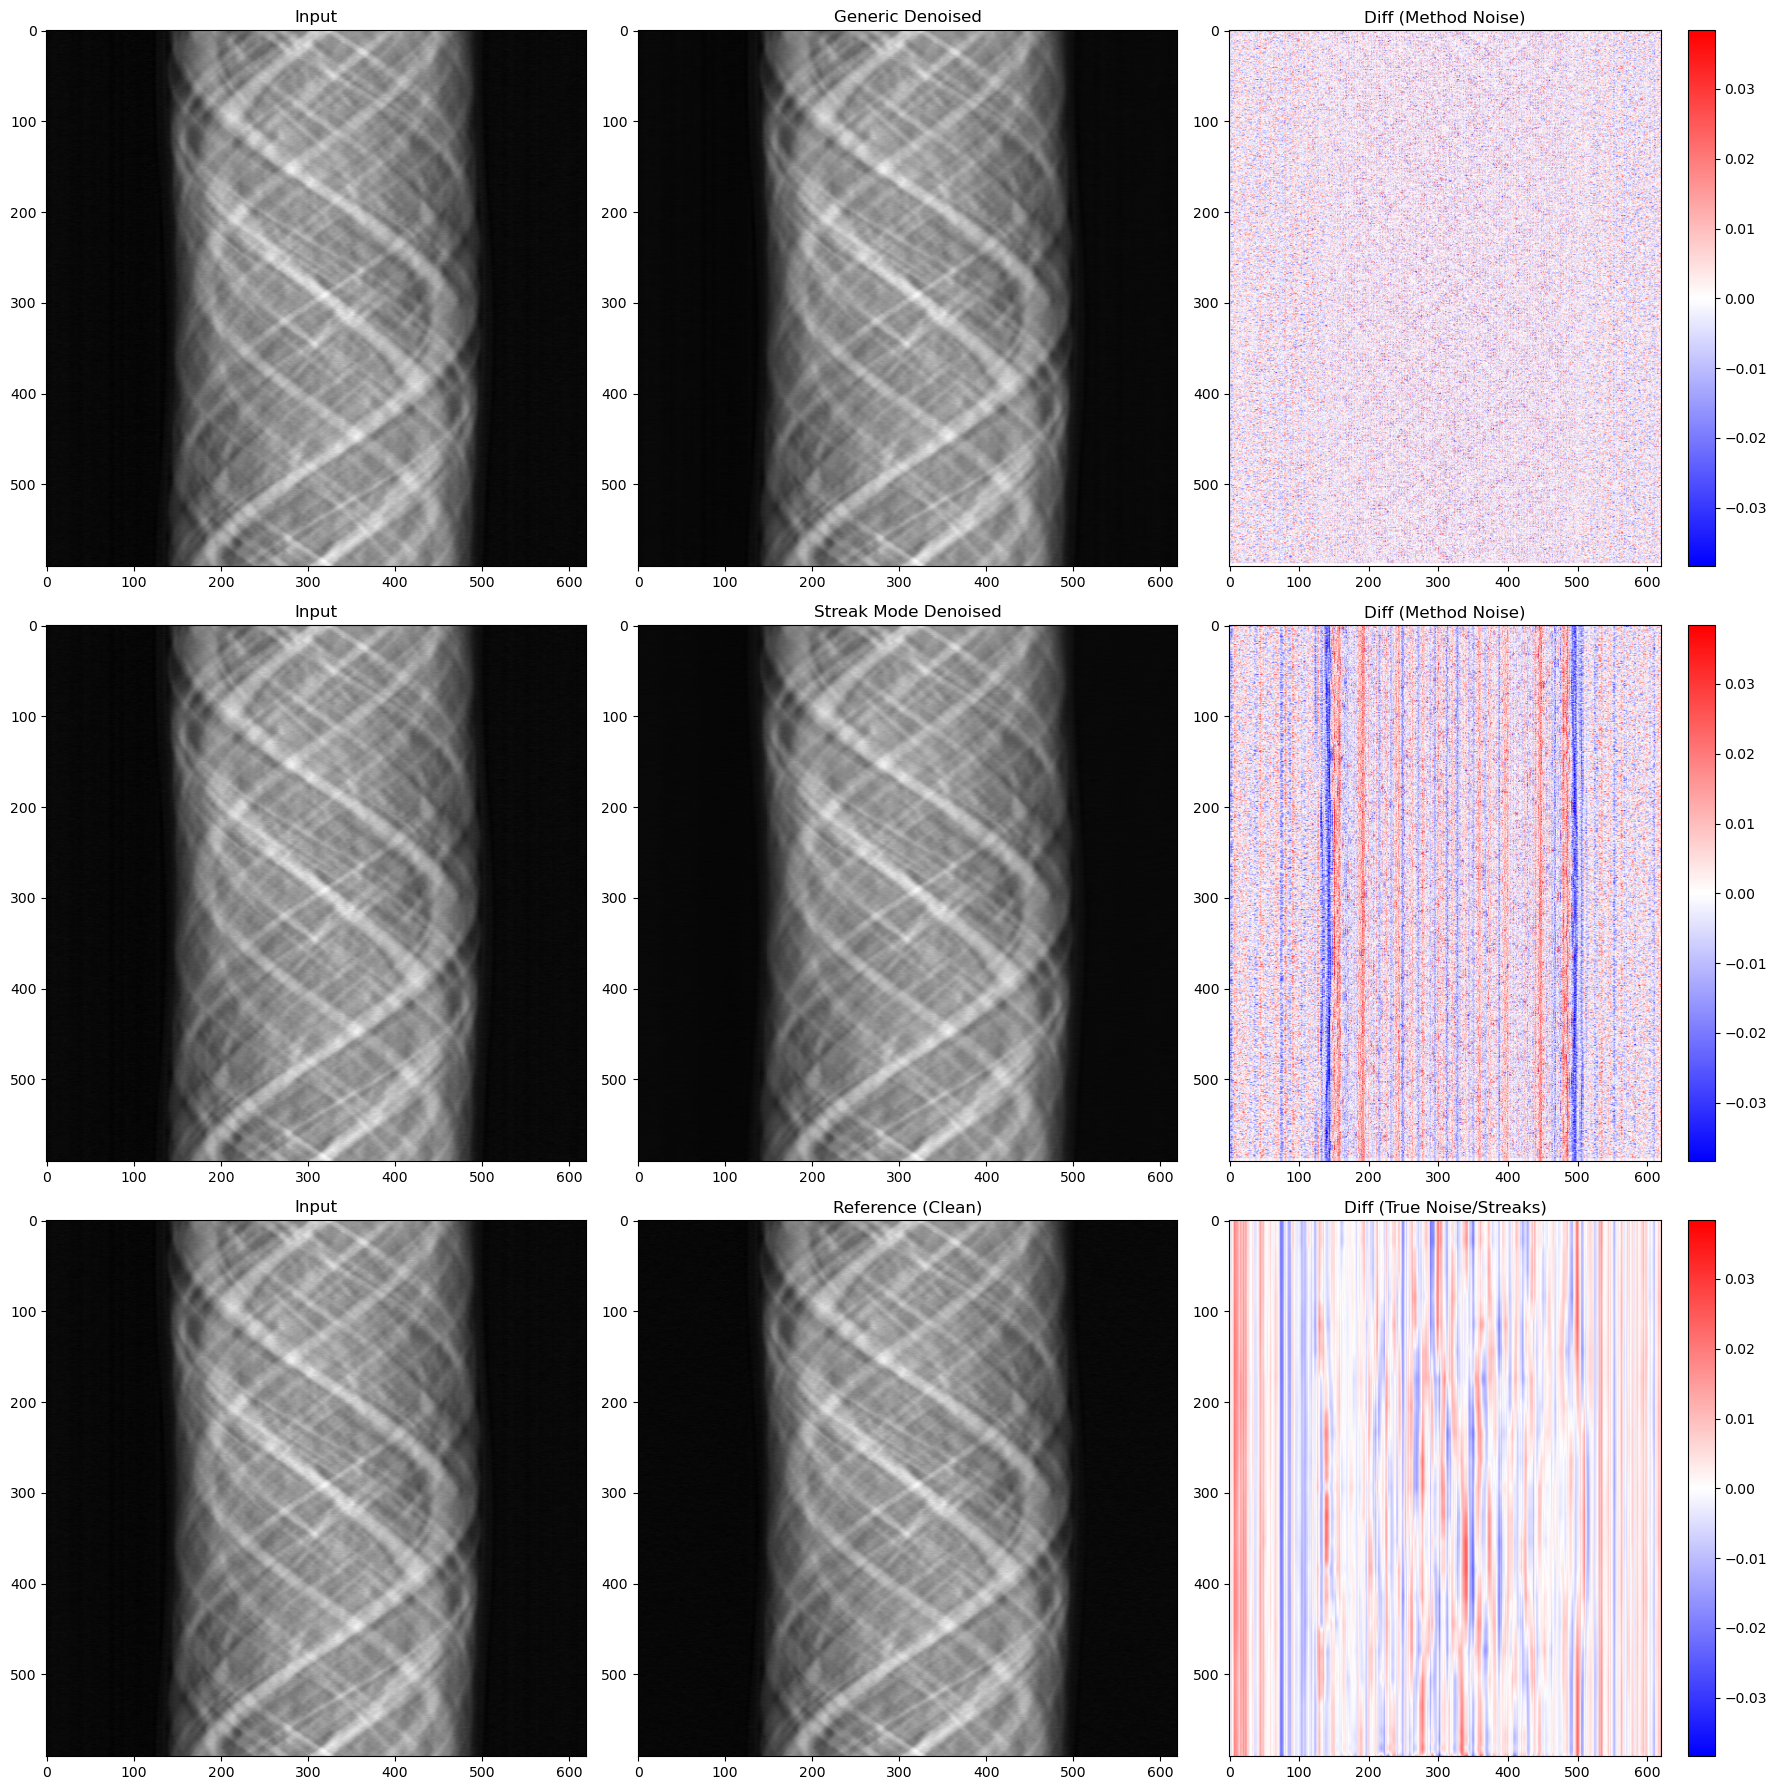

In [3]:
DATA_PATH = "../tests/bm3dornl-data/tomostack_small.h5"

try:
    with h5py.File(DATA_PATH, "r") as f:
        noisy_stack = f["noisy_tomostack"]
        clean_stack = f["clean_tomostack"]
        
        # Slice Y for Sinogram
        slice_y_idx = noisy_stack.shape[1] // 2
        noisy_sino = noisy_stack[:, slice_y_idx, :]
        clean_ref = clean_stack[:, slice_y_idx, :]
        
        print(f"Loaded Sinogram (Slice Y={slice_y_idx}), Shape: {noisy_sino.shape}")
        
        # 1. Run Generic Mode (using flat parameters)
        t0 = time.time()
        denoised_generic = bm3d_ring_artifact_removal(
            noisy_sino, mode="generic", sigma_random=0.005,
            patch_size=patch_size, max_matches=max_matches
        )
        t1 = time.time()
        
        # 2. Run Streak Mode (using flat parameters)
        t2 = time.time()
        denoised_streak = bm3d_ring_artifact_removal(
            noisy_sino, mode="streak", sigma_random=0.005,
            patch_size=patch_size, max_matches=max_matches
        )
        t3 = time.time()
        
        print(f"Generic Time: {t1-t0:.4f}s")
        print(f"Streak Mode Time: {t3-t2:.4f}s")
        
        # Metrics
        d_range = clean_ref.max() - clean_ref.min()
        
        def compute_psnr(img, ref):
             mse = np.mean((img - ref)**2)
             return 10 * np.log10(d_range**2 / mse)
             
        psnr_generic = compute_psnr(denoised_generic, clean_ref)
        psnr_streak = compute_psnr(denoised_streak, clean_ref)
        
        print(f"PSNR Generic: {psnr_generic:.2f} dB")
        print(f"PSNR Streak:  {psnr_streak:.2f} dB")
        
        # Visualization
        diff_clean = noisy_sino - clean_ref # True Streaks + Noise
        diff_generic = noisy_sino - denoised_generic
        diff_streak = noisy_sino - denoised_streak
        
        diff_max = max(np.abs(diff_generic).max(), np.abs(diff_clean).max()) * 0.8
        img_min, img_max = clean_ref.min(), clean_ref.max()

        fig, ax = plt.subplots(3, 3, figsize=(18, 18))
        
        # Row 1: Generic
        ax[0,0].imshow(noisy_sino, cmap='gray', aspect='auto', vmin=img_min, vmax=img_max); ax[0,0].set_title("Input")
        ax[0,1].imshow(denoised_generic, cmap='gray', aspect='auto', vmin=img_min, vmax=img_max); ax[0,1].set_title("Generic Denoised")
        im0 = ax[0,2].imshow(diff_generic, cmap='bwr', aspect='auto', vmin=-diff_max, vmax=diff_max); ax[0,2].set_title("Diff (Method Noise)")
        plt.colorbar(im0, ax=ax[0,2])

        # Row 2: Streak Mode
        ax[1,0].imshow(noisy_sino, cmap='gray', aspect='auto', vmin=img_min, vmax=img_max); ax[1,0].set_title("Input")
        ax[1,1].imshow(denoised_streak, cmap='gray', aspect='auto', vmin=img_min, vmax=img_max); ax[1,1].set_title("Streak Mode Denoised")
        im1 = ax[1,2].imshow(diff_streak, cmap='bwr', aspect='auto', vmin=-diff_max, vmax=diff_max); ax[1,2].set_title("Diff (Method Noise)")
        plt.colorbar(im1, ax=ax[1,2])
        
        # Row 3: Reference
        ax[2,0].imshow(noisy_sino, cmap='gray', aspect='auto', vmin=img_min, vmax=img_max); ax[2,0].set_title("Input")
        ax[2,1].imshow(clean_ref, cmap='gray', aspect='auto', vmin=img_min, vmax=img_max); ax[2,1].set_title("Reference (Clean)")
        im2 = ax[2,2].imshow(diff_clean, cmap='bwr', aspect='auto', vmin=-diff_max, vmax=diff_max); ax[2,2].set_title("Diff (True Noise/Streaks)")
        plt.colorbar(im2, ax=ax[2,2])
        
        plt.tight_layout()
        plt.show()
        
except FileNotFoundError:
    print("Test data not found.")
except Exception as e:
    print(f"Error: {e}")

Loaded Sinogram (Slice Y=11), Shape: (591, 620)
Generic Time: 0.2013s
Streak Mode Time: 0.2098s
PSNR Generic: 30.62 dB
PSNR Streak:  35.54 dB


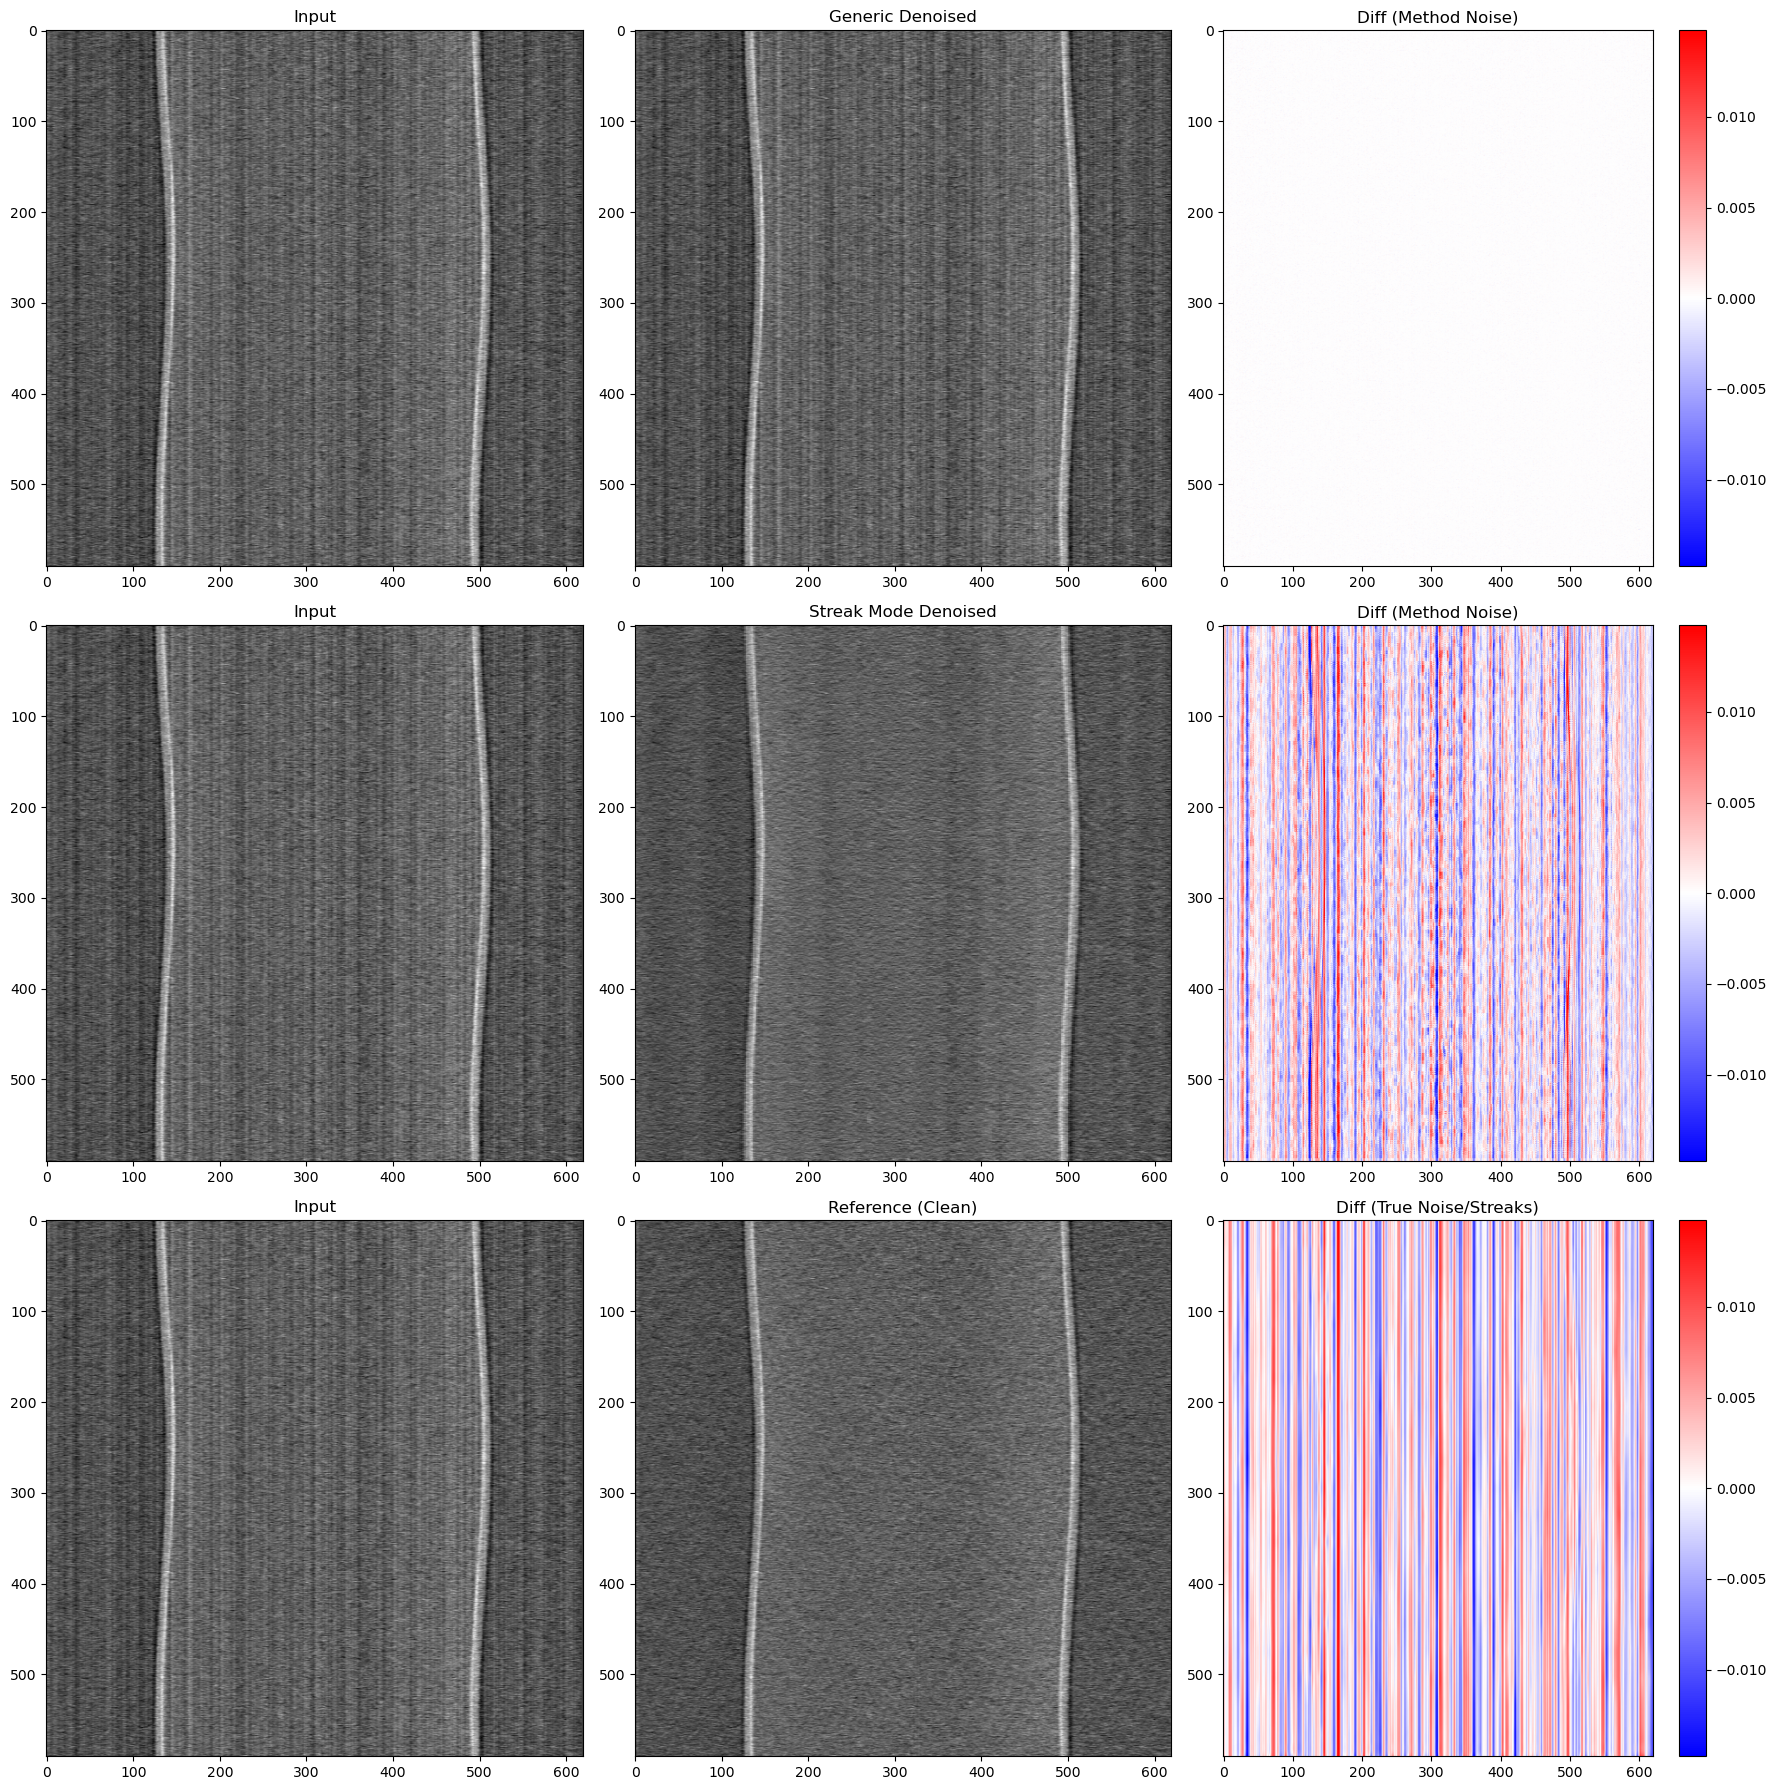

In [4]:
DATA_PATH = "../tests/bm3dornl-data/tomostack_small.h5"

try:
    with h5py.File(DATA_PATH, "r") as f:
        noisy_stack = f["noisy_tomostack"]
        clean_stack = f["clean_tomostack"]
        
        # Slice Y for Sinogram
        slice_y_idx = 11
        noisy_sino = noisy_stack[:, slice_y_idx, :]
        clean_ref = clean_stack[:, slice_y_idx, :]
        
        print(f"Loaded Sinogram (Slice Y={slice_y_idx}), Shape: {noisy_sino.shape}")
        
        # 1. Run Generic Mode (using flat parameters)
        t0 = time.time()
        denoised_generic = bm3d_ring_artifact_removal(
            noisy_sino, mode="generic", sigma_random=0.005,
            patch_size=patch_size, max_matches=max_matches
        )
        t1 = time.time()
        
        # 2. Run Streak Mode (using flat parameters)
        t2 = time.time()
        denoised_streak = bm3d_ring_artifact_removal(
            noisy_sino, mode="streak", sigma_random=0.005,
            patch_size=patch_size, max_matches=max_matches
        )
        t3 = time.time()
        
        print(f"Generic Time: {t1-t0:.4f}s")
        print(f"Streak Mode Time: {t3-t2:.4f}s")
        
        # Metrics
        d_range = clean_ref.max() - clean_ref.min()
        
        def compute_psnr(img, ref):
             mse = np.mean((img - ref)**2)
             return 10 * np.log10(d_range**2 / mse)
             
        psnr_generic = compute_psnr(denoised_generic, clean_ref)
        psnr_streak = compute_psnr(denoised_streak, clean_ref)
        
        print(f"PSNR Generic: {psnr_generic:.2f} dB")
        print(f"PSNR Streak:  {psnr_streak:.2f} dB")
        
        # Visualization
        diff_clean = noisy_sino - clean_ref # True Streaks + Noise
        diff_generic = noisy_sino - denoised_generic
        diff_streak = noisy_sino - denoised_streak
        
        diff_max = max(np.abs(diff_generic).max(), np.abs(diff_clean).max()) * 0.8
        img_min, img_max = clean_ref.min(), clean_ref.max()

        fig, ax = plt.subplots(3, 3, figsize=(18, 18))
        
        # Row 1: Generic
        ax[0,0].imshow(noisy_sino, cmap='gray', aspect='auto', vmin=img_min, vmax=img_max); ax[0,0].set_title("Input")
        ax[0,1].imshow(denoised_generic, cmap='gray', aspect='auto', vmin=img_min, vmax=img_max); ax[0,1].set_title("Generic Denoised")
        im0 = ax[0,2].imshow(diff_generic, cmap='bwr', aspect='auto', vmin=-diff_max, vmax=diff_max); ax[0,2].set_title("Diff (Method Noise)")
        plt.colorbar(im0, ax=ax[0,2])

        # Row 2: Streak Mode
        ax[1,0].imshow(noisy_sino, cmap='gray', aspect='auto', vmin=img_min, vmax=img_max); ax[1,0].set_title("Input")
        ax[1,1].imshow(denoised_streak, cmap='gray', aspect='auto', vmin=img_min, vmax=img_max); ax[1,1].set_title("Streak Mode Denoised")
        im1 = ax[1,2].imshow(diff_streak, cmap='bwr', aspect='auto', vmin=-diff_max, vmax=diff_max); ax[1,2].set_title("Diff (Method Noise)")
        plt.colorbar(im1, ax=ax[1,2])
        
        # Row 3: Reference
        ax[2,0].imshow(noisy_sino, cmap='gray', aspect='auto', vmin=img_min, vmax=img_max); ax[2,0].set_title("Input")
        ax[2,1].imshow(clean_ref, cmap='gray', aspect='auto', vmin=img_min, vmax=img_max); ax[2,1].set_title("Reference (Clean)")
        im2 = ax[2,2].imshow(diff_clean, cmap='bwr', aspect='auto', vmin=-diff_max, vmax=diff_max); ax[2,2].set_title("Diff (True Noise/Streaks)")
        plt.colorbar(im2, ax=ax[2,2])
        
        plt.tight_layout()
        plt.show()
        
except FileNotFoundError:
    print("Test data not found.")
except Exception as e:
    print(f"Error: {e}")